In [27]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import datetime
from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [60]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [61]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [18]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    print(new_columns)
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

import pandas as pd
df1=pd.DataFrame({'key':['a','b','a','b','b'],'value1':range(5)})
df2=pd.DataFrame({'key':['a','a','c','c','c'],'value1':range(5),'value3':range(5)})

merge_by_concat(df1,df2,["key","value1"])

['value3']


,key,value1,value3
0,a,0,0.0
1,b,1,NaN
2,a,2,NaN
3,b,3,NaN
4,b,4,NaN


In [19]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [24]:
print('Load Main Data')
# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv('sales_train_validation.csv')
prices_df = pd.read_csv('sell_prices.csv')
calendar_df = pd.read_csv('calendar.csv')


Load Main Data


In [22]:
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)
print(grid_df)
# If we look on train_df we see that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Create Grid
                                     id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
58327365    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
58327366    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
58327367    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
58327368    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
58327369    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sales  
0      

NameError: name 'np' is not defined

In [66]:
grid_df.head() #1-1913:train

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [67]:
grid_df.tail() #1914-1941:test

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
59181085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,NaN
59181089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,NaN


In [68]:
prices_df[(prices_df['store_id']=='CA_1') & (prices_df['item_id']=='FOODS_1_001')].head()

,store_id,item_id,wm_yr_wk,sell_price
368746,CA_1,FOODS_1_001,11101,2.0
368747,CA_1,FOODS_1_001,11102,2.0
368748,CA_1,FOODS_1_001,11103,2.0
368749,CA_1,FOODS_1_001,11104,2.0
368750,CA_1,FOODS_1_001,11105,2.0


In [25]:
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
print(release_df)
release_df.columns = ['store_id','item_id','release']

Release week
      store_id          item_id    min
0         CA_1      FOODS_1_001  11101
1         CA_1      FOODS_1_002  11101
2         CA_1      FOODS_1_003  11101
3         CA_1      FOODS_1_004  11206
4         CA_1      FOODS_1_005  11101
...        ...              ...    ...
30485     WI_3  HOUSEHOLD_2_512  11101
30486     WI_3  HOUSEHOLD_2_513  11311
30487     WI_3  HOUSEHOLD_2_514  11101
30488     WI_3  HOUSEHOLD_2_515  11352
30489     WI_3  HOUSEHOLD_2_516  11101

[30490 rows x 3 columns]


In [70]:
release_df.head() # release: the first wm_yr_wk has price

,store_id,item_id,release
0,CA_1,FOODS_1_001,11101
1,CA_1,FOODS_1_002,11101
2,CA_1,FOODS_1_003,11101
3,CA_1,FOODS_1_004,11206
4,CA_1,FOODS_1_005,11101


In [71]:
# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

In [72]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101


In [73]:
# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])

In [74]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101,11101
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101,11101
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101,11101
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101,11101
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101,11101


In [75]:
grid_df.shape

(59181090, 10)

In [76]:
# Now we can cutoff some rows 
# and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

    Original grid_df:   1.7GiB


In [77]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
576,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101,11101
11508,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101,11101
22440,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101,11101
33372,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101,11101
44304,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101,11101


In [78]:
grid_df.shape

(46881677, 10)

In [79]:
# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     Reduced grid_df:   1.5GiB


In [80]:
grid_df[(grid_df['store_id']=='CA_1') & (grid_df['item_id']=='FOODS_1_001')].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
576,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,0,11101
11508,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,0,11101
22440,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,0,11101
33372,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,0,11101
44304,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,0,11101


In [81]:
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle('grid_part_1.pkl')

print('Size:', grid_df.shape)

Save Part 1
Size: (46881677, 10)


In [82]:
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12.0,0,11101
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4.0,0,11101
5,HOBBIES_1_016_CA_1_validation,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,d_1,5.0,0,11101
6,HOBBIES_1_022_CA_1_validation,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
7,HOBBIES_1_023_CA_1_validation,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
8,HOBBIES_1_028_CA_1_validation,HOBBIES_1_028,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
9,HOBBIES_1_029_CA_1_validation,HOBBIES_1_029,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101


In [83]:
# add price feature
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [84]:
print('Prices')

# We can do some basic aggregations
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']


Prices


# #price_rank_dept

In [30]:
# price_rank_dept
prices_df["dept"]=prices_df["item_id"].apply(lambda x: x.split('_'))
print(prices_df["dept"])
prices_df["dept"]=prices_df["dept"].apply(lambda x: str(x[0:2]))
print(prices_df["dept"])
cat=prices_df["dept"].value_counts().index

a=pd.DataFrame()
k=10
for i in range(len(cat))    :
    temp=pd.cut(prices_df[prices_df["dept"]==cat[i]]['sell_price'],k,labels = range(k))
    a=pd.concat([a,temp])
a.columns=["price_rank_dept"]
a.sort_index(inplace=True)

prices_df=pd.concat([prices_df,a],axis=1)
prices_df["price_rank_dept"]=prices_df["price_rank_dept"].astype("category")
prices_df.drop(["dept"],axis=1,inplace=True)
del a,cat,k
gc.collect()

0          [HOBBIES, 1, 001]
1          [HOBBIES, 1, 001]
2          [HOBBIES, 1, 001]
3          [HOBBIES, 1, 001]
4          [HOBBIES, 1, 001]
                 ...        
6841116      [FOODS, 3, 827]
6841117      [FOODS, 3, 827]
6841118      [FOODS, 3, 827]
6841119      [FOODS, 3, 827]
6841120      [FOODS, 3, 827]
Name: dept, Length: 6841121, dtype: object
0          ['HOBBIES', '1']
1          ['HOBBIES', '1']
2          ['HOBBIES', '1']
3          ['HOBBIES', '1']
4          ['HOBBIES', '1']
                 ...       
6841116      ['FOODS', '3']
6841117      ['FOODS', '3']
6841118      ['FOODS', '3']
6841119      ['FOODS', '3']
6841120      ['FOODS', '3']
Name: dept, Length: 6841121, dtype: object


0

In [86]:
prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_rank_dept
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,2


In [87]:
prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')

0          3.0
1          3.0
2          3.0
3          3.0
4          3.0
5          3.0
6          3.0
7          3.0
8          3.0
9          3.0
10         3.0
11         3.0
12         3.0
13         3.0
14         3.0
15         3.0
16         3.0
17         3.0
18         3.0
19         3.0
20         3.0
21         3.0
22         3.0
23         3.0
24         3.0
25         3.0
26         3.0
27         3.0
28         3.0
29         3.0
          ... 
6841091    1.0
6841092    1.0
6841093    1.0
6841094    1.0
6841095    1.0
6841096    1.0
6841097    1.0
6841098    1.0
6841099    1.0
6841100    1.0
6841101    1.0
6841102    1.0
6841103    1.0
6841104    1.0
6841105    1.0
6841106    1.0
6841107    1.0
6841108    1.0
6841109    1.0
6841110    1.0
6841111    1.0
6841112    1.0
6841113    1.0
6841114    1.0
6841115    1.0
6841116    1.0
6841117    1.0
6841118    1.0
6841119    1.0
6841120    1.0
Name: sell_price, Length: 6841121, dtype: float64

In [88]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_rank_dept
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213,2
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213,2


In [89]:
# Some items are can be inflation dependent
# and some items are very "stable"
# check how many unique values each group has
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

In [90]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_rank_dept,price_nunique,item_nunique
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3.0,3
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3.0,3
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5


In [91]:
# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df['month'], prices_df['year']

In [92]:
prices_df.head(10)

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_rank_dept,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3.0,3,NaN,1.127059,1.145166
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3.0,3,1.000000,1.127059,1.145166
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,0.862213,0.971765,0.987377
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
5,CA_1,HOBBIES_1_001,11330,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
6,CA_1,HOBBIES_1_001,11331,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
7,CA_1,HOBBIES_1_001,11332,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
8,CA_1,HOBBIES_1_001,11333,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377
9,CA_1,HOBBIES_1_001,11334,8.26,9.58,8.26,0.152139,8.285714,0.862213,2,3.0,5,1.000000,1.000000,0.987377


In [93]:
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('grid_part_2.pkl')
print('Size:', grid_df.shape)

# We don't need prices_df anymore
del prices_df
gc.collect()

Merge prices and save part 2
Mem. usage decreased to 1834.59 Mb (61.7% reduction)
Size: (46881677, 14)


0

# calender feature

In [94]:
# add calender feature
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [95]:
calendar_df["event_name_1"].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [96]:
calendar_df["event_type_1"].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [31]:
## 上下半月
calendar_df['date']=pd.to_datetime(calendar_df['date'],format="%Y-%m-%d")
print(calendar_df)
# calendar_df['is_first_half_month']=
calendar_df['is_first_half_month']=[ 1 if x.day>=15 else 0  for x in calendar_df['date']]
calendar_df['is_first_half_month']=calendar_df['is_first_half_month'].astype("category")

           date  wm_yr_wk    weekday  wday  month  year       d  event_name_1  \
0    2011-01-29     11101   Saturday     1      1  2011     d_1           NaN   
1    2011-01-30     11101     Sunday     2      1  2011     d_2           NaN   
2    2011-01-31     11101     Monday     3      1  2011     d_3           NaN   
3    2011-02-01     11101    Tuesday     4      2  2011     d_4           NaN   
4    2011-02-02     11101  Wednesday     5      2  2011     d_5           NaN   
...         ...       ...        ...   ...    ...   ...     ...           ...   
1964 2016-06-15     11620  Wednesday     5      6  2016  d_1965           NaN   
1965 2016-06-16     11620   Thursday     6      6  2016  d_1966           NaN   
1966 2016-06-17     11620     Friday     7      6  2016  d_1967           NaN   
1967 2016-06-18     11621   Saturday     1      6  2016  d_1968           NaN   
1968 2016-06-19     11621     Sunday     2      6  2016  d_1969  NBAFinalsEnd   

     event_type_1  event_na

周级别处理(wday ==1,2 是weekedn)

In [98]:
# calendar_df=calendar_df.reset_index()
calendar_df["weekend"]=[ 1 if x<=2 else 0  for x in calendar_df['wday']]

calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_first_half_month,weekend
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,0,0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,0,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,0,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,0,0


In [99]:
calendar_df[~calendar_df["event_name_1"].isnull()].index

Int64Index([   8,   16,   23,   39,   46,   47,   50,   85,   87,   96,
            ...
            1881, 1884, 1918, 1919, 1923, 1926, 1948, 1951, 1956, 1968],
           dtype='int64', length=162)

# 节日前后处理 event_index

In [52]:
calendar_df["event_attention_after"]=np.nan
event_index=calendar_df[~calendar_df["event_name_1"].isnull()].index

for i in range(0,8):
    if event_index[-1]+i>=calendar_df.shape[0]:
        event_index=event_index[event_index<(event_index[-1]-i)]
    calendar_df.loc[event_index+i,"event_attention_after"]=7-i
calendar_df.loc[event_index,"event_attention_after"]=7

event_index=calendar_df[~calendar_df["event_name_1"].isnull()].index


Int64Index([   8,   16,   23,   39,   46,   47,   50,   85,   87,   96,
            ...
            1874, 1881, 1884, 1918, 1919, 1923, 1926, 1948, 1951, 1956],
           dtype='int64', length=161)
Int64Index([   8,   16,   23,   39,   46,   47,   50,   85,   87,   96,
            ...
            1845, 1874, 1881, 1884, 1918, 1919, 1923, 1926, 1948, 1951],
           dtype='int64', length=160)


In [101]:
calendar_df.head(100)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_first_half_month,weekend,event_attention_after
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1,1,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1,1,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1,0,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0,NaN
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,0,0,NaN
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,0,0,NaN
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,0,1,NaN
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,0,1,7.0
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,0,0,6.0


In [59]:
calendar_df["event_attention_bef"]=np.nan
for i in range(0,8):
    calendar_df.loc[calendar_df[~calendar_df["event_name_1"].isnull()].index-i,"event_attention_bef"]=i*-1
calendar_df.loc[calendar_df[~calendar_df["event_name_1"].isnull()].index,"event_attention_bef"]=0

In [60]:
calendar_df["event_attention_sum"]=calendar_df["event_attention_bef"]+calendar_df["event_attention_after"]

In [61]:
calendar_df["event_bef_weekend"]=np.nan
event_round_index=calendar_df[~calendar_df["event_attention_bef"].isnull()]
calendar_df.loc[event_round_index[event_round_index.wday<=2].index,"event_bef_weekend"]=1
calendar_df.loc[event_index,"event_bef_weekend"]=0

In [62]:
calendar_df["event_after_weekend"]=np.nan
event_round_index=calendar_df[~calendar_df["event_attention_after"].isnull()]
calendar_df.loc[event_round_index[event_round_index.wday<=2].index,"event_after_weekend"]=1
calendar_df.loc[event_index,"event_after_weekend"]=0


In [63]:
calendar_df.head(50)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_first_half_month,event_attention_after,event_after_weekend,event_attention_bef,event_attention_sum,event_bef_weekend
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1,NaN,NaN,-7.0,NaN,1.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1,NaN,NaN,-6.0,NaN,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,NaN,NaN,-5.0,NaN,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,NaN,NaN,-4.0,NaN,NaN
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,0,NaN,NaN,-3.0,NaN,NaN
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,0,NaN,NaN,-2.0,NaN,NaN
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,0,NaN,NaN,-1.0,NaN,1.0
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,0,7.0,0.0,0.0,7.0,0.0
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,0,6.0,NaN,-7.0,-1.0,NaN


#  NBA

In [106]:
# Lent
# 大斋节亦称“封斋节”，是基督教的斋戒节期。据《新约圣经》载，耶稣于开始传教前在旷野守斋祈祷40昼夜。教会为表示纪念，规定棕枝主日前的40天为此节期。
# 教徒在此期间一般于星期五守大斋和小斋。

# Chanukah End
# 欢庆光明节的人往往会烹制油炸食品，以此象征亮了8天的灯油传奇。特色节日佳肴包括犹太薯饼（latkes）以及有果酱夹心的犹太甜甜圈（sufganya）。



In [107]:
# 赛事数据
calendar_df["NBA"]=np.nan
calendar_df["date"]=pd.to_datetime(calendar_df["date"])
#http://www.uhchina.com/lanqiu/2013-2014nba/
# http://sports.sina.com.cn/nba/playoff1213.html
a=[[2011,5,31],[2011,6,2],[2011,6,5],[2011,6,7],[2011,6,9],[2011,6,12],
   [2012,6,12],[2012,6,14],[2012,6,17],[2012,6,19],[2012,6,21],
   [2013,6,6],[2013,6,9],[2013,6,11],[2013,6,13],[2013,6,16],[2013,6,18],[2013,6,20],
   [2014,6,5],[2014,6,8],[2014,6,10],[2014,6,12],[2014,6,15], 
   [2015,6,4],[2015,6,7],[2015,6,9],[2015,6,11],[2015,6,14], [2015,6,16],
   [2016,6,2],[2016,6,5],[2016,6,8],[2016,6,10],[2016,6,13],[2016,6,16] ,[2016,6,19]
  ]
for i in range(0,len(a)):
    calendar_df.loc[calendar_df[calendar_df["date"]==datetime.datetime(*a[i])].index,"NBA"]=1

In [108]:
calendar_df[calendar_df["NBA"]==1]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,...,snap_TX,snap_WI,is_first_half_month,weekend,event_attention_after,event_attention_bef,event_attention_sum,event_bef_weekend,event_after_weekend,NBA
122,2011-05-31,11118,Tuesday,4,5,2011,d_123,NBAFinalsStart,Sporting,NaN,...,0,0,1,0,7.0,0.0,7.0,0.0,0.0,1.0
124,2011-06-02,11118,Thursday,6,6,2011,d_125,NaN,NaN,NaN,...,0,1,0,0,4.0,NaN,NaN,NaN,NaN,1.0
127,2011-06-05,11119,Sunday,2,6,2011,d_128,NaN,NaN,NaN,...,1,1,0,1,1.0,-7.0,-6.0,1.0,1.0,1.0
129,2011-06-07,11119,Tuesday,4,6,2011,d_130,NaN,NaN,NaN,...,1,0,0,0,0.0,-5.0,-5.0,NaN,NaN,1.0
131,2011-06-09,11119,Thursday,6,6,2011,d_132,NaN,NaN,NaN,...,1,1,0,0,NaN,-3.0,NaN,NaN,NaN,1.0
134,2011-06-12,11120,Sunday,2,6,2011,d_135,NBAFinalsEnd,Sporting,NaN,...,1,1,0,1,7.0,0.0,7.0,0.0,0.0,1.0
500,2012-06-12,11220,Tuesday,4,6,2012,d_501,NBAFinalsStart,Sporting,NaN,...,1,1,0,0,7.0,0.0,7.0,0.0,0.0,1.0
502,2012-06-14,11220,Thursday,6,6,2012,d_503,NaN,NaN,NaN,...,0,1,0,0,5.0,-7.0,-2.0,NaN,NaN,1.0
505,2012-06-17,11221,Sunday,2,6,2012,d_506,Father's day,Cultural,NaN,...,0,0,1,1,7.0,0.0,7.0,0.0,0.0,1.0
507,2012-06-19,11221,Tuesday,4,6,2012,d_508,NaN,NaN,NaN,...,0,0,1,0,0.0,-2.0,-2.0,NaN,NaN,1.0


# SNAP

In [109]:
calendar_df["snap_TX"]

0       0
1       0
2       0
3       1
4       0
5       1
6       0
7       1
8       1
9       1
10      0
11      1
12      0
13      1
14      1
15      1
16      0
17      1
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1939    0
1940    0
1941    0
1942    0
1943    0
1944    0
1945    0
1946    0
1947    0
1948    0
1949    0
1950    1
1951    0
1952    1
1953    0
1954    1
1955    1
1956    1
1957    0
1958    1
1959    0
1960    1
1961    1
1962    1
1963    0
1964    1
1965    0
1966    0
1967    0
1968    0
Name: snap_TX, Length: 1969, dtype: int64

In [110]:
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12.0,0,11101
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4.0,0,11101
5,HOBBIES_1_016_CA_1_validation,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,d_1,5.0,0,11101
6,HOBBIES_1_022_CA_1_validation,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
7,HOBBIES_1_023_CA_1_validation,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
8,HOBBIES_1_028_CA_1_validation,HOBBIES_1_028,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
9,HOBBIES_1_029_CA_1_validation,HOBBIES_1_029,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101


In [55]:
#周末函数是否有问题？

In [111]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 22 columns):
date                     1969 non-null datetime64[ns]
wm_yr_wk                 1969 non-null int64
weekday                  1969 non-null object
wday                     1969 non-null int64
month                    1969 non-null int64
year                     1969 non-null int64
d                        1969 non-null object
event_name_1             162 non-null object
event_type_1             162 non-null object
event_name_2             5 non-null object
event_type_2             5 non-null object
snap_CA                  1969 non-null int64
snap_TX                  1969 non-null int64
snap_WI                  1969 non-null int64
is_first_half_month      1969 non-null category
weekend                  1969 non-null int64
event_attention_after    1031 non-null float64
event_attention_bef      1038 non-null float64
event_attention_sum      536 non-null float64
event_bef_weekend      

In [112]:
calendar_df.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'is_first_half_month', 'weekend',
       'event_attention_after', 'event_attention_bef', 'event_attention_sum',
       'event_bef_weekend', 'event_after_weekend', 'NBA'],
      dtype='object')

In [113]:
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         #category
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI', 
         'is_first_half_month', 
         'event_bef_weekend', 
         'event_after_weekend',
         'NBA',
         
         
         # numerical
        'event_attention_after',
         'event_attention_bef',
         'event_attention_sum',

        ]
grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI', 
         'is_first_half_month', 
         'event_bef_weekend', 
         'event_after_weekend',
         'NBA']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

grid_df['event_attention_after'] = grid_df['event_attention_after'].astype(np.float16) #day of month  
grid_df['event_attention_bef'] = grid_df['event_attention_bef'].astype(np.float16) #day of month  
grid_df['event_attention_sum'] = grid_df['event_attention_sum'].astype(np.float16) #day of month  
    
    
    
# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8) #day of month
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8) # week of year
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8) # month of year
grid_df['tm_q'] = grid_df['date'].dt.quarter.astype(np.int8) # quarter of year
grid_df['tm_y'] = grid_df['date'].dt.year # year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8) # minus min(year)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8) # week of month

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8) # day of week: monday start from 0, so saturday. is 5
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8) # weekend and weekday

# Remove date
del grid_df['date']

In [114]:
grid_df['tm_dw']

0           5
1           5
2           5
3           5
4           5
5           5
6           5
7           5
8           5
9           5
10          5
11          5
12          5
13          5
14          5
15          5
16          5
17          5
18          5
19          5
20          5
21          5
22          5
23          5
24          5
25          5
26          5
27          5
28          5
29          5
           ..
46881647    6
46881648    6
46881649    6
46881650    6
46881651    6
46881652    6
46881653    6
46881654    6
46881655    6
46881656    6
46881657    6
46881658    6
46881659    6
46881660    6
46881661    6
46881662    6
46881663    6
46881664    6
46881665    6
46881666    6
46881667    6
46881668    6
46881669    6
46881670    6
46881671    6
46881672    6
46881673    6
46881674    6
46881675    6
46881676    6
Name: tm_dw, Length: 46881677, dtype: int8

In [115]:
grid_df.head()

,id,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_first_half_month,...,event_attention_bef,event_attention_sum,tm_d,tm_w,tm_m,tm_q,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_008_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,29,4,1,1,0,5,5,1
1,HOBBIES_1_009_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,29,4,1,1,0,5,5,1
2,HOBBIES_1_010_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,29,4,1,1,0,5,5,1
3,HOBBIES_1_012_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,29,4,1,1,0,5,5,1
4,HOBBIES_1_015_CA_1_validation,d_1,NaN,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,29,4,1,1,0,5,5,1


In [116]:
print('Save part 3')

# Safe part 3
grid_df.to_pickle('grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

Save part 3
Size: (46881677, 24)


In [118]:
## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
del grid_df['wm_yr_wk']
grid_df.to_pickle('grid_part_1.pkl')

del grid_df

In [119]:
# Now we have 3 sets of features
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
                     
# Let's check again memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

           Full Grid:   3.0GiB
Size: (46881677, 43)


In [120]:
# add lag feature
grid_df = pd.read_pickle('grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]
SHIFT_DAY = 28

In [121]:
# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,28,56,168]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,28,56]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
5.37 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 56
Rolling period: 168
Shifting period: 1
Shifting period: 7
Shifting period: 14
10.91 min: Lags


In [122]:
grid_df[grid_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:60]

,id,d,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,...,rolling_mean_tmp_1_28,rolling_mean_tmp_1_56,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_28,rolling_mean_tmp_7_56,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_28,rolling_mean_tmp_14_56
16838178,HOBBIES_1_001_CA_1_validation,897,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16862809,HOBBIES_1_001_CA_1_validation,898,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16887440,HOBBIES_1_001_CA_1_validation,899,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16912071,HOBBIES_1_001_CA_1_validation,900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16936702,HOBBIES_1_001_CA_1_validation,901,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16961333,HOBBIES_1_001_CA_1_validation,902,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16985964,HOBBIES_1_001_CA_1_validation,903,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17010595,HOBBIES_1_001_CA_1_validation,904,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17035335,HOBBIES_1_001_CA_1_validation,905,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17060075,HOBBIES_1_001_CA_1_validation,906,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 40 columns):
id                        category
d                         int16
sales                     float64
sales_lag_28              float16
sales_lag_29              float16
sales_lag_30              float16
sales_lag_31              float16
sales_lag_32              float16
sales_lag_33              float16
sales_lag_34              float16
sales_lag_35              float16
sales_lag_36              float16
sales_lag_37              float16
sales_lag_38              float16
sales_lag_39              float16
sales_lag_40              float16
sales_lag_41              float16
sales_lag_42              float16
rolling_mean_7            float16
rolling_std_7             float16
rolling_mean_14           float16
rolling_std_14            float16
rolling_mean_28           float16
rolling_std_28            float16
rolling_mean_56           float16
rolling_std_56            float16
ro

In [124]:
print('Save lags and rollings')
grid_df.to_pickle('lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [125]:
# group aggregation
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df[TARGET][grid_df['d']>(1913-28)] = np.nan
base_cols = list(grid_df)

icols =  [
            ['state_id'],
            ['store_id'],
            ['cat_id'],
            ['dept_id'],
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std'] = grid_df.groupby(col)[TARGET].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]
grid_df = grid_df[['id','d']+keep_cols]

Encoding ['state_id']
Encoding ['store_id']
Encoding ['cat_id']
Encoding ['dept_id']
Encoding ['state_id', 'cat_id']
Encoding ['state_id', 'dept_id']
Encoding ['store_id', 'cat_id']
Encoding ['store_id', 'dept_id']
Encoding ['item_id']
Encoding ['item_id', 'state_id']
Encoding ['item_id', 'store_id']


In [126]:
grid_df[grid_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:60]

,id,d,enc_state_id_mean,enc_state_id_std,enc_store_id_mean,enc_store_id_std,enc_cat_id_mean,enc_cat_id_std,enc_dept_id_mean,enc_dept_id_std,...,enc_store_id_cat_id_mean,enc_store_id_cat_id_std,enc_store_id_dept_id_mean,enc_store_id_dept_id_std,enc_item_id_mean,enc_item_id_std,enc_item_id_state_id_mean,enc_item_id_state_id_std,enc_item_id_store_id_mean,enc_item_id_store_id_std
16838178,HOBBIES_1_001_CA_1_validation,897,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16862809,HOBBIES_1_001_CA_1_validation,898,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16887440,HOBBIES_1_001_CA_1_validation,899,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16912071,HOBBIES_1_001_CA_1_validation,900,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16936702,HOBBIES_1_001_CA_1_validation,901,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16961333,HOBBIES_1_001_CA_1_validation,902,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
16985964,HOBBIES_1_001_CA_1_validation,903,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17010595,HOBBIES_1_001_CA_1_validation,904,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17035335,HOBBIES_1_001_CA_1_validation,905,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402
17060075,HOBBIES_1_001_CA_1_validation,906,1.576172,4.605469,1.639648,4.476562,0.708984,2.259766,0.865234,2.544922,...,1.004883,3.128906,1.261719,3.548828,0.402588,0.739258,0.619629,0.896973,0.57959,0.837402


In [127]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 24 columns):
id                           category
d                            int16
enc_state_id_mean            float16
enc_state_id_std             float16
enc_store_id_mean            float16
enc_store_id_std             float16
enc_cat_id_mean              float16
enc_cat_id_std               float16
enc_dept_id_mean             float16
enc_dept_id_std              float16
enc_state_id_cat_id_mean     float16
enc_state_id_cat_id_std      float16
enc_state_id_dept_id_mean    float16
enc_state_id_dept_id_std     float16
enc_store_id_cat_id_mean     float16
enc_store_id_cat_id_std      float16
enc_store_id_dept_id_mean    float16
enc_store_id_dept_id_std     float16
enc_item_id_mean             float16
enc_item_id_std              float16
enc_item_id_state_id_mean    float16
enc_item_id_state_id_std     float16
enc_item_id_store_id_mean    float16
enc_item_id_store_id_std     float1

In [128]:
print('Save Mean/Std encoding')
grid_df.to_pickle('mean_encoding_df.pkl')

Save Mean/Std encoding


In [129]:
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [130]:
N_CORES = psutil.cpu_count()     # Available CPU cores

#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows if needed(Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon

In [131]:
#PATHS for Features
BASE     = 'grid_part_1.pkl'
PRICE    = 'grid_part_2.pkl'
CALENDAR = 'grid_part_3.pkl'
LAGS     = 'lags_df_28.pkl'
MEAN_ENC = 'mean_encoding_df.pkl'

In [132]:
grid_df = pd.concat([pd.read_pickle(BASE),
                pd.read_pickle(PRICE).iloc[:,2:],
                pd.read_pickle(CALENDAR).iloc[:,2:]],
                axis=1)

In [133]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 43 columns):
id                       category
item_id                  category
dept_id                  category
cat_id                   category
store_id                 category
state_id                 category
d                        int16
sales                    float64
release                  int16
sell_price               float16
price_max                float16
price_min                float16
price_std                float16
price_mean               float16
price_norm               float16
price_rank_dept          category
price_nunique            float16
item_nunique             int16
price_momentum           float16
price_momentum_m         float16
price_momentum_y         float16
event_name_1             category
event_type_1             category
event_name_2             category
event_type_2             category
snap_CA                  category
snap_TX              

In [134]:
df2 = pd.read_pickle(MEAN_ENC)
df2 = df2[df2.index.isin(grid_df.index)]

In [135]:
df3 = pd.read_pickle(LAGS).iloc[:,3:]
df3 = df3[df3.index.isin(grid_df.index)]

In [136]:
grid_df = pd.concat([grid_df, df2], axis=1)
del df2

In [137]:
grid_df = pd.concat([grid_df, df3], axis=1)
del df3 

In [138]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Columns: 104 entries, id to rolling_mean_tmp_14_56
dtypes: category(19), float16(72), float64(1), int16(4), int8(8)
memory usage: 8.3 GB


In [139]:
(grid_df.dtypes).tolist()

[CategoricalDtype(categories=['FOODS_1_001_CA_1_validation', 'FOODS_1_001_CA_2_validation',
                   'FOODS_1_001_CA_3_validation', 'FOODS_1_001_CA_4_validation',
                   'FOODS_1_001_TX_1_validation', 'FOODS_1_001_TX_2_validation',
                   'FOODS_1_001_TX_3_validation', 'FOODS_1_001_WI_1_validation',
                   'FOODS_1_001_WI_2_validation', 'FOODS_1_001_WI_3_validation',
                   ...
                   'HOUSEHOLD_2_516_CA_1_validation',
                   'HOUSEHOLD_2_516_CA_2_validation',
                   'HOUSEHOLD_2_516_CA_3_validation',
                   'HOUSEHOLD_2_516_CA_4_validation',
                   'HOUSEHOLD_2_516_TX_1_validation',
                   'HOUSEHOLD_2_516_TX_2_validation',
                   'HOUSEHOLD_2_516_TX_3_validation',
                   'HOUSEHOLD_2_516_WI_1_validation',
                   'HOUSEHOLD_2_516_WI_2_validation',
                   'HOUSEHOLD_2_516_WI_3_validation'],
                  or

In [140]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,rolling_mean_tmp_1_28,rolling_mean_tmp_1_56,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_28,rolling_mean_tmp_7_56,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_28,rolling_mean_tmp_14_56
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,0,0.459961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,0,1.559570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,3.169922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0,5.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4.0,0,0.700195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
grid_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,rolling_mean_tmp_1_28,rolling_mean_tmp_1_56,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_28,rolling_mean_tmp_7_56,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_28,rolling_mean_tmp_14_56
46881672,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,2.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881673,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,2.480469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881674,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,NaN,0,3.980469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881675,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,NaN,230,1.280273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46881676,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1941,NaN,304,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Let's check our memory usage
print("{:>20}: {:>8}".format('size of grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

     size of grid_df:   8.3GiB


In [143]:
grid_df.to_pickle('df_full.pkl')

In [145]:
del grid_df
gc.collect()

160

In [ ]:
#跑到这里即可

# model

In [146]:
#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows if needed(Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon

In [147]:
grid_df=pd.read_pickle('df_full.pkl')

In [148]:
grid_df.columns=['id',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'sales',
 'release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_rank_dept',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'is_first_half_month',
 'event_bef_weekend',
 'event_after_weekend',
 'NBA',
 'event_attention_after',
 'event_attention_bef',
 'event_attention_sum',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_q',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end',
 'id_1',
 'd_1',
 'enc_state_id_mean',
 'enc_state_id_std',
 'enc_store_id_mean',
 'enc_store_id_std',
 'enc_cat_id_mean',
 'enc_cat_id_std',
 'enc_dept_id_mean',
 'enc_dept_id_std',
 'enc_state_id_cat_id_mean',
 'enc_state_id_cat_id_std',
 'enc_state_id_dept_id_mean',
 'enc_state_id_dept_id_std',
 'enc_store_id_cat_id_mean',
 'enc_store_id_cat_id_std',
 'enc_store_id_dept_id_mean',
 'enc_store_id_dept_id_std',
 'enc_item_id_mean',
 'enc_item_id_std',
 'enc_item_id_state_id_mean',
 'enc_item_id_state_id_std',
 'enc_item_id_store_id_mean',
 'enc_item_id_store_id_std',
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_32',
 'sales_lag_33',
 'sales_lag_34',
 'sales_lag_35',
 'sales_lag_36',
 'sales_lag_37',
 'sales_lag_38',
 'sales_lag_39',
 'sales_lag_40',
 'sales_lag_41',
 'sales_lag_42',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_28',
 'rolling_std_28',
 'rolling_mean_56',
 'rolling_std_56',
 'rolling_mean_168',
 'rolling_std_168',
 'rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_mean_tmp_1_28',
 'rolling_mean_tmp_1_56',
 'rolling_mean_tmp_7_7',
 'rolling_mean_tmp_7_14',
 'rolling_mean_tmp_7_28',
 'rolling_mean_tmp_7_56',
 'rolling_mean_tmp_14_7',
 'rolling_mean_tmp_14_14',
 'rolling_mean_tmp_14_28',
 'rolling_mean_tmp_14_56']

In [149]:
features = [
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 
 # price features
 'release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_rank_dept',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
            
# caland         
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'is_first_half_month',
 'event_bef_weekend',
 'event_after_weekend',
 'NBA',
 'event_attention_after',
 'event_attention_bef',
 'event_attention_sum',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_q',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end',
# agg
 'enc_state_id_mean',
 'enc_state_id_std',
 'enc_store_id_mean',
 'enc_store_id_std',
 'enc_cat_id_mean',
 'enc_cat_id_std',
 'enc_dept_id_mean',
 'enc_dept_id_std',
 'enc_state_id_cat_id_mean',
 'enc_state_id_cat_id_std',
 'enc_state_id_dept_id_mean',
 'enc_state_id_dept_id_std',
 'enc_store_id_cat_id_mean',
 'enc_store_id_cat_id_std',
 'enc_store_id_dept_id_mean',
 'enc_store_id_dept_id_std',
 'enc_item_id_mean',
 'enc_item_id_std',
 'enc_item_id_state_id_mean',
 'enc_item_id_state_id_std',
 'enc_item_id_store_id_mean',
 'enc_item_id_store_id_std',
 # demand features.           
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_32',
 'sales_lag_33',
 'sales_lag_34',
 'sales_lag_35',
 'sales_lag_36',
 'sales_lag_37',
 'sales_lag_38',
 'sales_lag_39',
 'sales_lag_40',
 'sales_lag_41',
 'sales_lag_42',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_28',
 'rolling_std_28',
 'rolling_mean_56',
 'rolling_std_56',
 'rolling_mean_168',
 'rolling_std_168',
 'rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_mean_tmp_1_28',
 'rolling_mean_tmp_1_56',
 'rolling_mean_tmp_7_7',
 'rolling_mean_tmp_7_14',
 'rolling_mean_tmp_7_28',
 'rolling_mean_tmp_7_56',
 'rolling_mean_tmp_14_7',
 'rolling_mean_tmp_14_14',
 'rolling_mean_tmp_14_28',
 'rolling_mean_tmp_14_56']

In [150]:
grid_df.columns[43:45]

Index(['id_1', 'd_1'], dtype='object')

In [151]:
grid_df.drop(grid_df.columns[43:45], axis=1,inplace=True)

In [152]:
train_mask = grid_df['d']<=(END_TRAIN-P_HORIZON)
valid_mask = (grid_df['d']>(END_TRAIN-P_HORIZON)) & (grid_df['d']<=END_TRAIN)

In [153]:
import lightgbm as lgb
train_data = lgb.Dataset(grid_df[train_mask][features], label=grid_df[train_mask][TARGET])

In [154]:
valid_data = lgb.Dataset(grid_df[valid_mask][features], label=grid_df[valid_mask][TARGET])

In [155]:
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    '`boost_from_average': False,
                    'verbose': -1,
                    "gpu_hist":True
                } 

In [156]:
fit_params = {"num_boost_round": 100_000,
              "early_stopping_rounds": 50,
              "verbose_eval": 100,}

In [157]:
 model = lgb.train(lgb_params,
                   train_data,
                   valid_sets=[train_data, valid_data],
                   **fit_params,)

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.40514	valid_1's rmse: 1.93208
[200]	training's rmse: 2.32319	valid_1's rmse: 1.91133
[300]	training's rmse: 2.28091	valid_1's rmse: 1.90489
[400]	training's rmse: 2.2542	valid_1's rmse: 1.90216
[500]	training's rmse: 2.23612	valid_1's rmse: 1.90079
[600]	training's rmse: 2.21904	valid_1's rmse: 1.89905
[700]	training's rmse: 2.20524	valid_1's rmse: 1.89857
[800]	training's rmse: 2.19334	valid_1's rmse: 1.89766
[900]	training's rmse: 2.18252	valid_1's rmse: 1.89741
[1000]	training's rmse: 2.1729	valid_1's rmse: 1.89705
[1100]	training's rmse: 2.16396	valid_1's rmse: 1.89682
Early stopping, best iteration is:
[1088]	training's rmse: 2.16503	valid_1's rmse: 1.89666


In [158]:
from mlflow_extend import mlflow, plotting as mplt

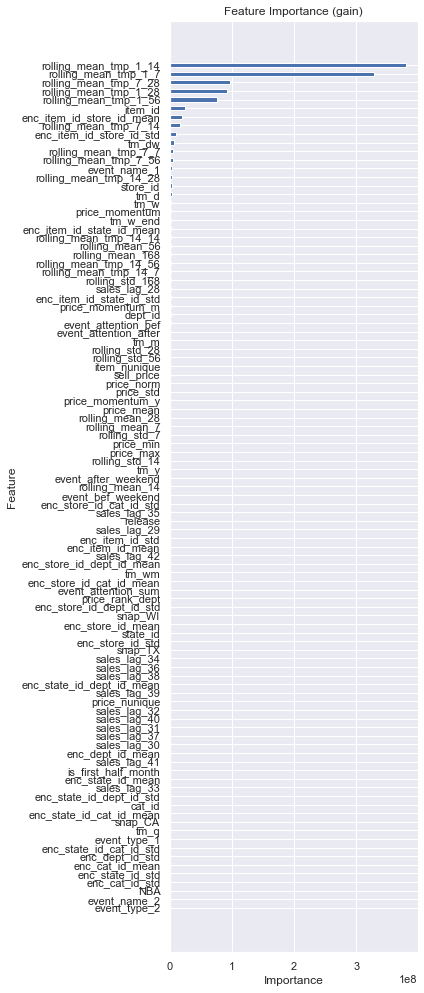

In [159]:
imp_type = "gain"
features = model.feature_name()
importances = model.feature_importance(imp_type)
_ = mplt.feature_importance(features, importances, imp_type)

In [160]:
importance_df=pd.DataFrame(features,columns=['features'])
importance_df['importances']=importances
importance_df=importance_df.sort_values(by='importances', ascending=False)
importance_df

,features,importances
88,rolling_mean_tmp_1_14,3.796495e+08
87,rolling_mean_tmp_1_7,3.292048e+08
93,rolling_mean_tmp_7_28,9.625186e+07
89,rolling_mean_tmp_1_28,9.227151e+07
90,rolling_mean_tmp_1_56,7.625828e+07
0,item_id,2.344109e+07
60,enc_item_id_store_id_mean,2.007469e+07
92,rolling_mean_tmp_7_14,1.611771e+07
61,enc_item_id_store_id_std,9.372756e+06
38,tm_dw,6.109877e+06
